In [29]:
import numpy as np
import pandas as pd
import sklearn as sk

I begin by importing the various metrics that would be used to build the model. The vast majority of data cleaning was done on excel for the sake of simplicity. The data was collecting from StatHead's Fbref. For each group of metrics, a total of 10 files, each with 200 observations except for the last one, were merged to produce the final file. I now import them below.

In [31]:
xg = pd.read_csv("xg.csv", encoding='ISO-8859-1')
passes = pd.read_csv("passes.csv", encoding='ISO-8859-1')
defstats = pd.read_csv("def.csv", encoding='ISO-8859-1')

I will first check the shape to ensure that they have the same number of observations.

In [32]:
xg.shape

(1810, 39)

In [33]:
passes.shape

(1810, 41)

In [34]:
defstats.shape

(1810, 24)

For the sake of reference and copy-pasting, I will now print out the columns

In [6]:
xg.columns

Index(['Rk', 'Player', 'xG/90', 'Season', 'Age', 'Nation', 'Team', 'Comp',
       'MP', 'Min', '90s', 'Starts', 'Subs', 'unSub', 'Gls', 'Ast', 'G+A',
       'G-PK', 'PK', 'PKatt', 'PKm', 'xG/90.1', 'npxG', 'xAG', 'xG+xAG', 'xA',
       'npxG+xAG', 'G-xG', 'np:G-xG', 'A-xAG', 'npxG/Sh', 'Sh', 'G/Sh',
       'G/SoT', 'SoT', 'SoT%', 'Dist', 'FK', 'Pos'],
      dtype='object')

In [7]:
passes.columns

Index(['Rk', 'Player', 'Cmp/90', 'Season', 'Age', 'Nation', 'Team', 'Comp',
       'MP', 'Min', '90s', 'Starts', 'Subs', 'unSub', 'Gls', 'Ast', 'G+A',
       'G-PK', 'PK', 'PKatt', 'PKm', 'TotalCmp/90', 'TotalAtt', 'TotalCmp%',
       'TotalKP', 'passesToFinalThird', 'PPA', 'CrsPA', 'PrgP', 'TotDist',
       'PrgDist', 'ShortCmp', 'ShortAtt', 'ShortCmp%', 'MedCmp', 'MedAtt',
       'MedCmp%', 'LongCmp', 'LongAtt', 'LongCmp%', 'Pos'],
      dtype='object')

In [8]:
defstats.columns

Index(['Rk', 'Player', 'Season', 'Age', 'Nation', 'Team', 'Comp', 'Tkl/90',
       'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Challenges Tkl',
       'ChallengesAtt', 'Challenges Tkl%', 'Challenges Lost', 'Blocks',
       'Sh Blocks', 'Pass Blocks', 'Int', 'Tkl+Int', 'Clr', 'Err', 'Pos'],
      dtype='object')

Below, I merge the dataframes through a two step process. 

In [35]:
passes_clean = passes.drop(columns=["Gls", "Ast", "G+A", "G-PK", "PK", "PKatt", "PKm"])

df = pd.merge(
    xg,
    passes_clean,
    on=["Player", "Season", "Team", "Comp", "Age", "Nation", "Pos"],
)

df = pd.merge(
    df,
    defstats,
    on=["Player", "Season", "Team", "Comp", "Age", "Nation", "Pos"],
)

df.columns

Index(['Rk_x', 'Player', 'xG/90', 'Season', 'Age', 'Nation', 'Team', 'Comp',
       'MP_x', 'Min_x', '90s_x', 'Starts_x', 'Subs_x', 'unSub_x', 'Gls', 'Ast',
       'G+A', 'G-PK', 'PK', 'PKatt', 'PKm', 'xG/90.1', 'npxG', 'xAG', 'xG+xAG',
       'xA', 'npxG+xAG', 'G-xG', 'np:G-xG', 'A-xAG', 'npxG/Sh', 'Sh', 'G/Sh',
       'G/SoT', 'SoT', 'SoT%', 'Dist', 'FK', 'Pos', 'Rk_y', 'Cmp/90', 'MP_y',
       'Min_y', '90s_y', 'Starts_y', 'Subs_y', 'unSub_y', 'TotalCmp/90',
       'TotalAtt', 'TotalCmp%', 'TotalKP', 'passesToFinalThird', 'PPA',
       'CrsPA', 'PrgP', 'TotDist', 'PrgDist', 'ShortCmp', 'ShortAtt',
       'ShortCmp%', 'MedCmp', 'MedAtt', 'MedCmp%', 'LongCmp', 'LongAtt',
       'LongCmp%', 'Rk', 'Tkl/90', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd',
       'Challenges Tkl', 'ChallengesAtt', 'Challenges Tkl%', 'Challenges Lost',
       'Blocks', 'Sh Blocks', 'Pass Blocks', 'Int', 'Tkl+Int', 'Clr', 'Err'],
      dtype='object')

For this initial model, I will be using all the metrics at my disposal to produce the model. So, I define the feature set to include all metrics that I believe would be useful to compare players. However, one may notice that multiple variables are correlated, which will lead to multi-collinearity. Although this will not necessarily stop the model from producing reasonable output, it is in my best interest to remove certain variables so as to curb the bias that may occur from including correlated metrics. For this reason, I will remove the following statistics: 'Challenges Tkl%', 'xG+xAG', 'npxG+xAG', 'MedCmp%', 'LongCmp%', 'ShortCmp%'.

In [36]:
features = [
    "Gls", "Ast", "G+A",                # output
    "xG/90", "npxG", "xAG", 
    "Sh", "SoT", "Dist",   # xG stuff
    "Cmp/90", "TotalCmp/90", "TotalCmp%", "TotalKP", 
    "passesToFinalThird", "PPA", "CrsPA", "PrgP",  # passing
    'TotDist', 'PrgDist', 'ShortCmp', 'ShortAtt',
    'MedCmp', 'MedAtt', 'LongCmp', 'LongAtt',
    'Tkl/90', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Challenges Tkl', #defensive stats
    'ChallengesAtt', 'Challenges Lost', 'Blocks',
    'Sh Blocks', 'Pass Blocks', 'Int', 'Tkl+Int', 'Clr', 'Err'
]
df = df.fillna(0)
X = df[features]

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
model = NearestNeighbors(metric="cosine", algorithm="brute")
model.fit(X_scaled)

NearestNeighbors(algorithm='brute', metric='cosine')

In [45]:
def find_similar(player_name, n=5):
    idx = df.index[df["Player"] == player_name][0]
    player_vec = X_scaled[idx].reshape(1, -1)
    distances, indices = model.kneighbors(player_vec, n_neighbors=n+1)

    results = df.iloc[indices[0][1:]][["Player", "Team", "Season", "Pos", "Gls", "Ast", "G+A"]]
    results["SimilarityScore"] = 1 - distances[0][1:]
    return results

# Example
print(find_similar("James Maddison", n=5))

              Player             Team     Season    Pos  Gls  Ast  G+A  \
68              Isco            Betis  2024-2025     MF  0.5  0.5  1.0   
474      Lee Kang-in        Paris S-G  2024-2025  FW,MF  0.3  0.3  0.6   
400     Rayan Cherki             Lyon  2024-2025  FW,MF  0.4  0.5  0.8   
310  Kevin De Bruyne  Manchester City  2024-2025  MF,FW  0.2  0.4  0.6   
417      Xavi Simons       RB Leipzig  2024-2025     MF  0.4  0.3  0.7   

     SimilarityScore  
68          0.928987  
474         0.843953  
400         0.838409  
310         0.808232  
417         0.806563  


C:\Users\tejas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


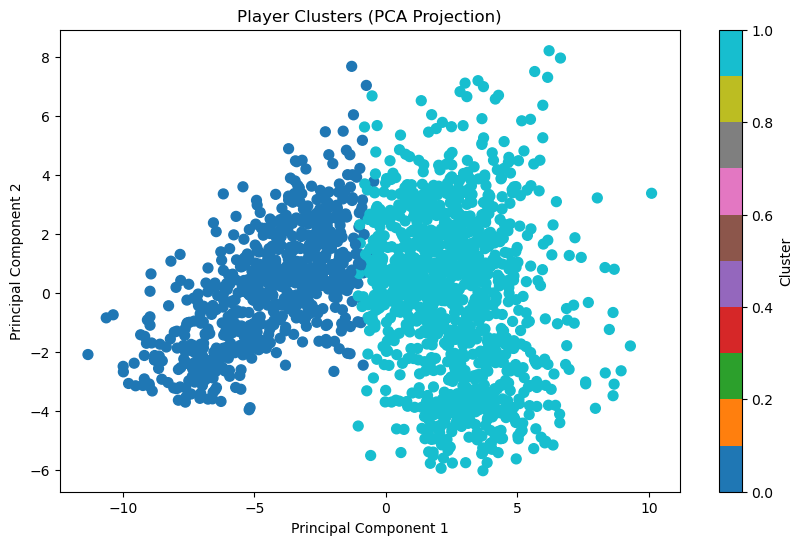

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

X = df.select_dtypes(include='number') 

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df['Cluster'] = clusters
df['PC1'] = X_pca[:,0]
df['PC2'] = X_pca[:,1]

# Plot
plt.figure(figsize=(10,6))
plt.scatter(df['PC1'], df['PC2'], c=df['Cluster'], cmap='tab10', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Player Clusters (PCA Projection)')
plt.colorbar(label='Cluster')
plt.show()